In [1]:
import pandas as pd
import os,shutil,math,scipy,cv2
import numpy as np
import matplotlib.pyplot as plt
import random as rn


from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,roc_curve,auc

from PIL import Image
from PIL import Image as pil_image
from PIL import ImageDraw

from time import time
from glob import glob
from tqdm import tqdm
from skimage.io import imread
from IPython.display import SVG

from scipy import misc,ndimage
from scipy.ndimage.interpolation import zoom
# from scipy.ndimage import imread


from keras import backend as K
from keras.utils.np_utils import to_categorical
from keras import layers
from keras.preprocessing.image import save_img
from keras.utils.vis_utils import model_to_dot
# from keras.applications.vgg16 import VGG16,preprocess_input
from keras.models import Sequential,Input,Model,load_model
from keras.layers import Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D,Lambda,ZeroPadding2D,BatchNormalization,MaxPool2D
from keras.layers import SeparableConv2D,BatchNormalization,MaxPooling2D,Conv2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,SGD
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler

import pydot
from tensorflow.keras.losses import CategoricalCrossentropy

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix
import seaborn as sn

from keras.applications.resnet_v2 import ResNet152V2, preprocess_input

In [2]:
# MODEL IMAGES PATHS
path_to_resNet_model_image = "model_images/resNet.png"

# MODEL WEIGHTS PATHS
# set always net path for weights
path_to_resNet_model_weights = "./resNet_weights/resNet_model_weights"

# CSV LOGS PATHS
path_to_resNet_csvlog = "./csv_logs/resNet"

# JSON MODEL PRESENTATION PATHS
resNet_model_json_path = "./json_models/resNet.json"

# MODEL PATHS
path_to_resNet_model = "./models/resNet"


# Number of epochs hyperparameter
num_of_epochs = 100

In [3]:
RANDOM_STATE = 1234

In [4]:
# PATH TO FOOD IMAGES
beans = 'images/BEANS'
cake = 'images/CAKE'
candy = 'images/CANDY'
cereal = 'images/CEREAL'
chips = 'images/CHIPS'
chocolate = 'images/CHOCOLATE'
coffee = 'images/COFFEE'
corn = 'images/CORN'
fish = 'images/FISH'
flour = 'images/FLOUR'
honey = 'images/HONEY'
jam = 'images/JAM'
juice = 'images/JUICE'
milk = 'images/MILK'
nuts = 'images/NUTS'
oil = 'images/OIL'
pasta = 'images/PASTA'
rice = 'images/RICE'
soda = 'images/SODA'
spices = 'images/SPICES'
sugar = 'images/SUGAR'
tea = 'images/TEA'
tomato_sauce = 'images/TOMATO_SAUCE'
vinegar = 'images/VINEGAR'
water = 'images/WATER'

X = []
Z = []
imgsize = 150

In [5]:
def training_data(label,data_dir):
    for img in tqdm(os.listdir(data_dir)):
        path = os.path.join(data_dir,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img,(imgsize,imgsize))
        
        X.append(np.array(img))
        Z.append(str(label))

In [6]:
def print_model(model, model_name):
    plot_model(model, to_file = model_name, show_shapes=True, show_layer_names=True)
    SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [7]:
def resNet_model(img_rows, img_cols):
    base_model = ResNet152V2(include_top=False,
                          input_shape = (img_rows,img_cols,3),
                          weights='imagenet')
    for layer in base_model.layers:
        layer.trainable = False

    for layer in base_model.layers:
        print(layer,layer.trainable)

    model = Sequential()
    model.add(base_model)
#     my layers
    model.add(GlobalAveragePooling2D())
    model.add(Dense(3072,activation='relu'))
    model.add(Dropout(0.35))
    model.add(Dense(25,activation='softmax'))
    model.summary()
    
    return model

In [8]:
def plot_acc_loss(history, num_of_epochs):
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.plot(np.arange(0, num_of_epochs), history.history['loss'], label='train')
    plt.plot(np.arange(0, num_of_epochs), history.history['val_loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.plot(np.arange(0, num_of_epochs), history.history['accuracy'], label='train')
    plt.plot(np.arange(0, num_of_epochs), history.history['val_accuracy'], label='val')
    plt.legend(loc='best')

    plt.show()

In [9]:
def evaluate_model(model,x_test,y_test,classes_names,conf_matrix_name):
    score = model.evaluate(x_test, y_test, verbose=1)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    y_predicted = model.predict(x_test)
    y_predicted_classes = np.argmax(y_predicted, axis = 1)
    y_test_classes = np.argmax(y_test, axis = 1)
    
    conf_mat = confusion_matrix(y_test_classes, y_predicted_classes)
    
    df_cm = pd.DataFrame(conf_mat, index = [i for i in classes_names],
                  columns = [i for i in classes_names])
    plt.figure(figsize = (16,12))
    plt.title(conf_matrix_name)
    sn.heatmap(df_cm, annot=True)
    plt.savefig('./confusion_matrices/' + conf_matrix_name)
    
    report = classification_report(y_test_classes, y_predicted_classes)
    print(report)
    
    
    y_predicted_classes.shape, y_test_classes.shape

In [10]:
def write_model_as_json(model, path):
    model_json = model.to_json()
    with open(path,"w") as json_file:
        json_file.write(model_json)

In [11]:
training_data('beans',beans)
training_data('cake',cake)
training_data('candy',candy)
training_data('cereal',cereal)
training_data('chips',chips)
training_data('chocolate',chocolate)
training_data('coffee',coffee)
training_data('corn',corn)
training_data('fish',fish)
training_data('flour',flour)
training_data('honey',honey)
training_data('jam',jam)
training_data('juice',juice)
training_data('milk',milk)
training_data('nuts',nuts)
training_data('oil',oil)
training_data('pasta',pasta)
training_data('rice',rice)
training_data('soda',soda)
training_data('spices',spices)
training_data('sugar',sugar)
training_data('tea',tea)
training_data('tomato sauce',tomato_sauce)
training_data('vinegar',vinegar)
training_data('water',water)

100%|██████████| 262/262 [00:01<00:00, 171.78it/s]


In [12]:
# shape of image
X[0].shape

(150, 150, 3)

In [13]:
# image data format
K.image_data_format()

'channels_last'

In [14]:
len(X),len(Z)

(4947, 4947)

In [15]:
label_encoder= LabelEncoder()
Y = label_encoder.fit_transform(Z)

In [16]:
Y

array([ 0,  0,  0, ..., 24, 24, 24], dtype=int64)

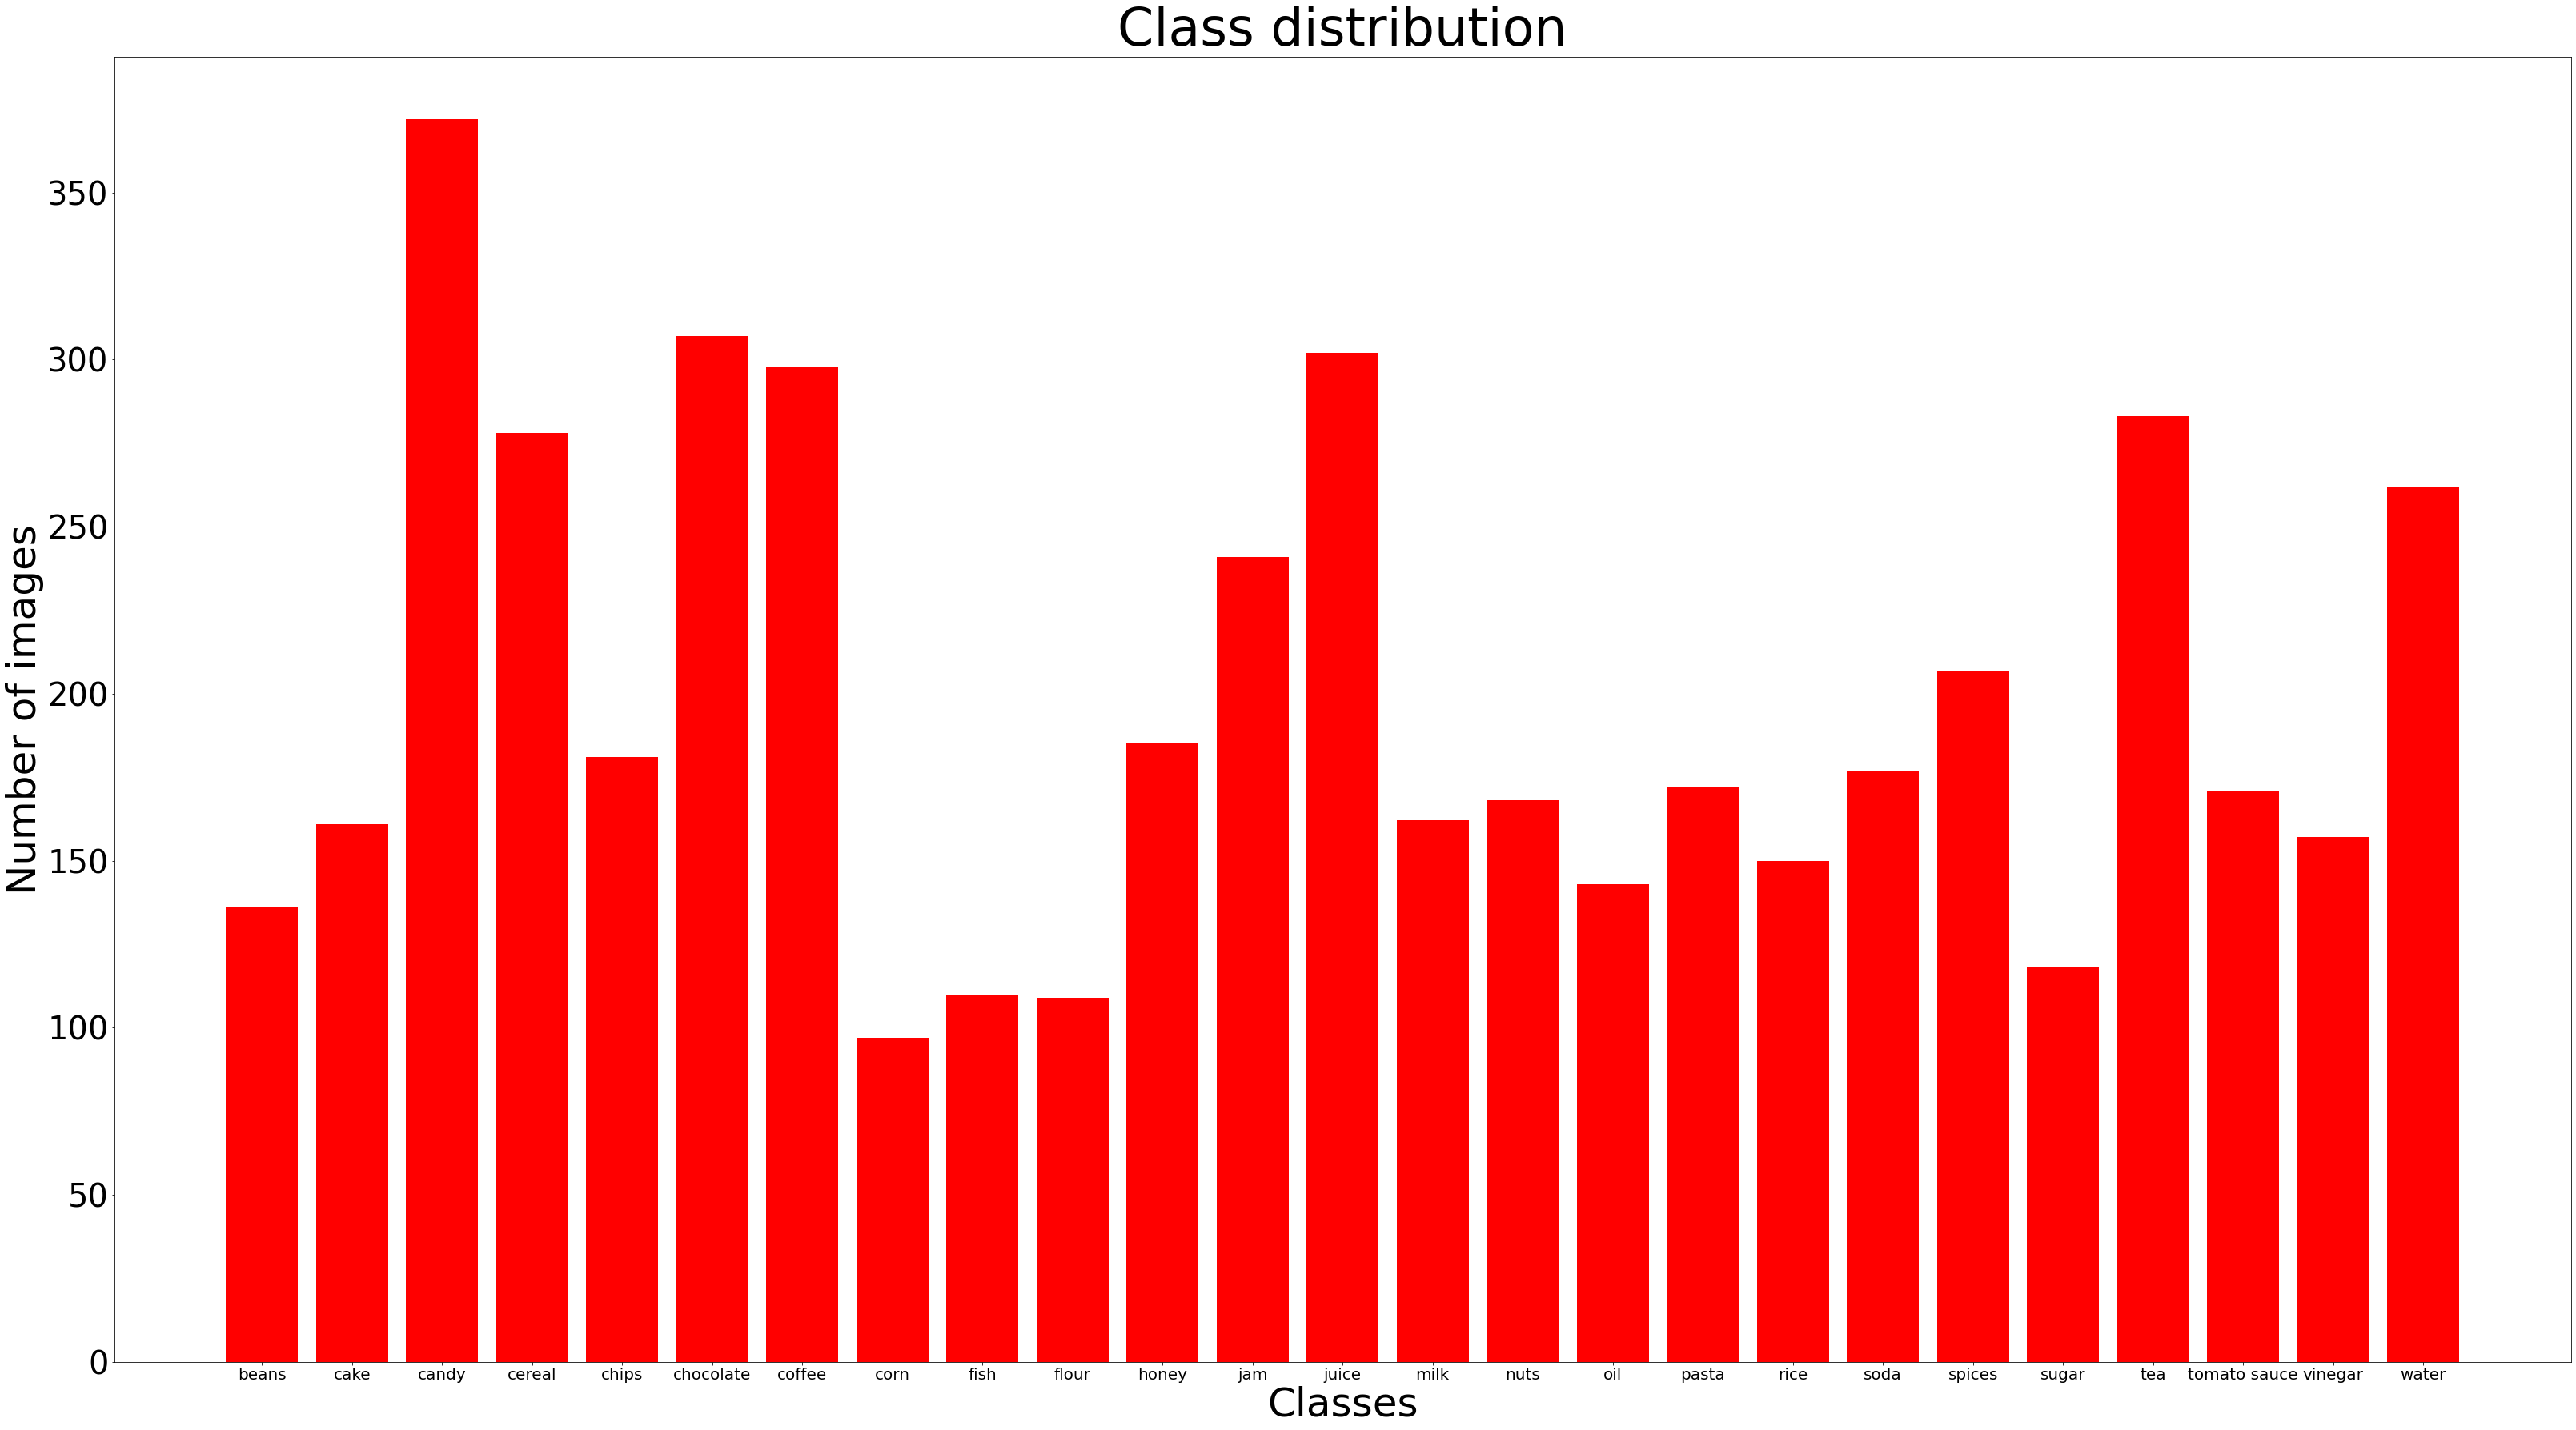

In [17]:
# bar diagram of class distribution
classes_names = ['beans','cake','candy','cereal','chips','chocolate','coffee','corn','fish','flour','honey',
                'jam','juice','milk','nuts','oil','pasta','rice','soda','spices','sugar','tea','tomato sauce','vinegar','water']
plt.figure(figsize=(55,30))
plt.title('Class distribution', fontsize=65)
plt.xlabel('Classes', fontsize=50)
plt.ylabel('Number of images', fontsize=50)
plt.xticks(fontsize= 20)
plt.yticks(fontsize= 40)
plt.bar(classes_names,np.bincount(Y), color = 'r')
plt.show()

In [18]:
Y = to_categorical(Y,25)

In [19]:
Y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [20]:
# The images are converted from RGB to BGR, then each color channel is zero-centered with respect to the ImageNet dataset, without scaling.
X = np.array(X)
X = preprocess_input(X)
# we can preprocess input on imageDataGenerator

In [21]:
X.shape,Y.shape

((4947, 150, 150, 3), (4947, 25))

In [22]:
# train - test - val split
# x_train_val, x_test, y_train_val, y_test = train_test_split(X,Y,test_size=0.2,random_state=RANDOM_STATE,stratify=Y)
# x_train, x_val, y_train, y_val = train_test_split(x_train_val,y_train_val,test_size=0.2,random_state=RANDOM_STATE,stratify=y_train_val)
# x_train.shape,y_train.shape,x_val.shape,y_val.shape,x_test.shape,y_test.shape

# split only on x_train - y_train because we will use ImageDataGenerator on x_train for validation instances
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.3,random_state=RANDOM_STATE,stratify=Y)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((3462, 150, 150, 3), (1485, 150, 150, 3), (3462, 25), (1485, 25))

In [23]:
# CHECK IF X_TEST HAVE ALL CLASSES

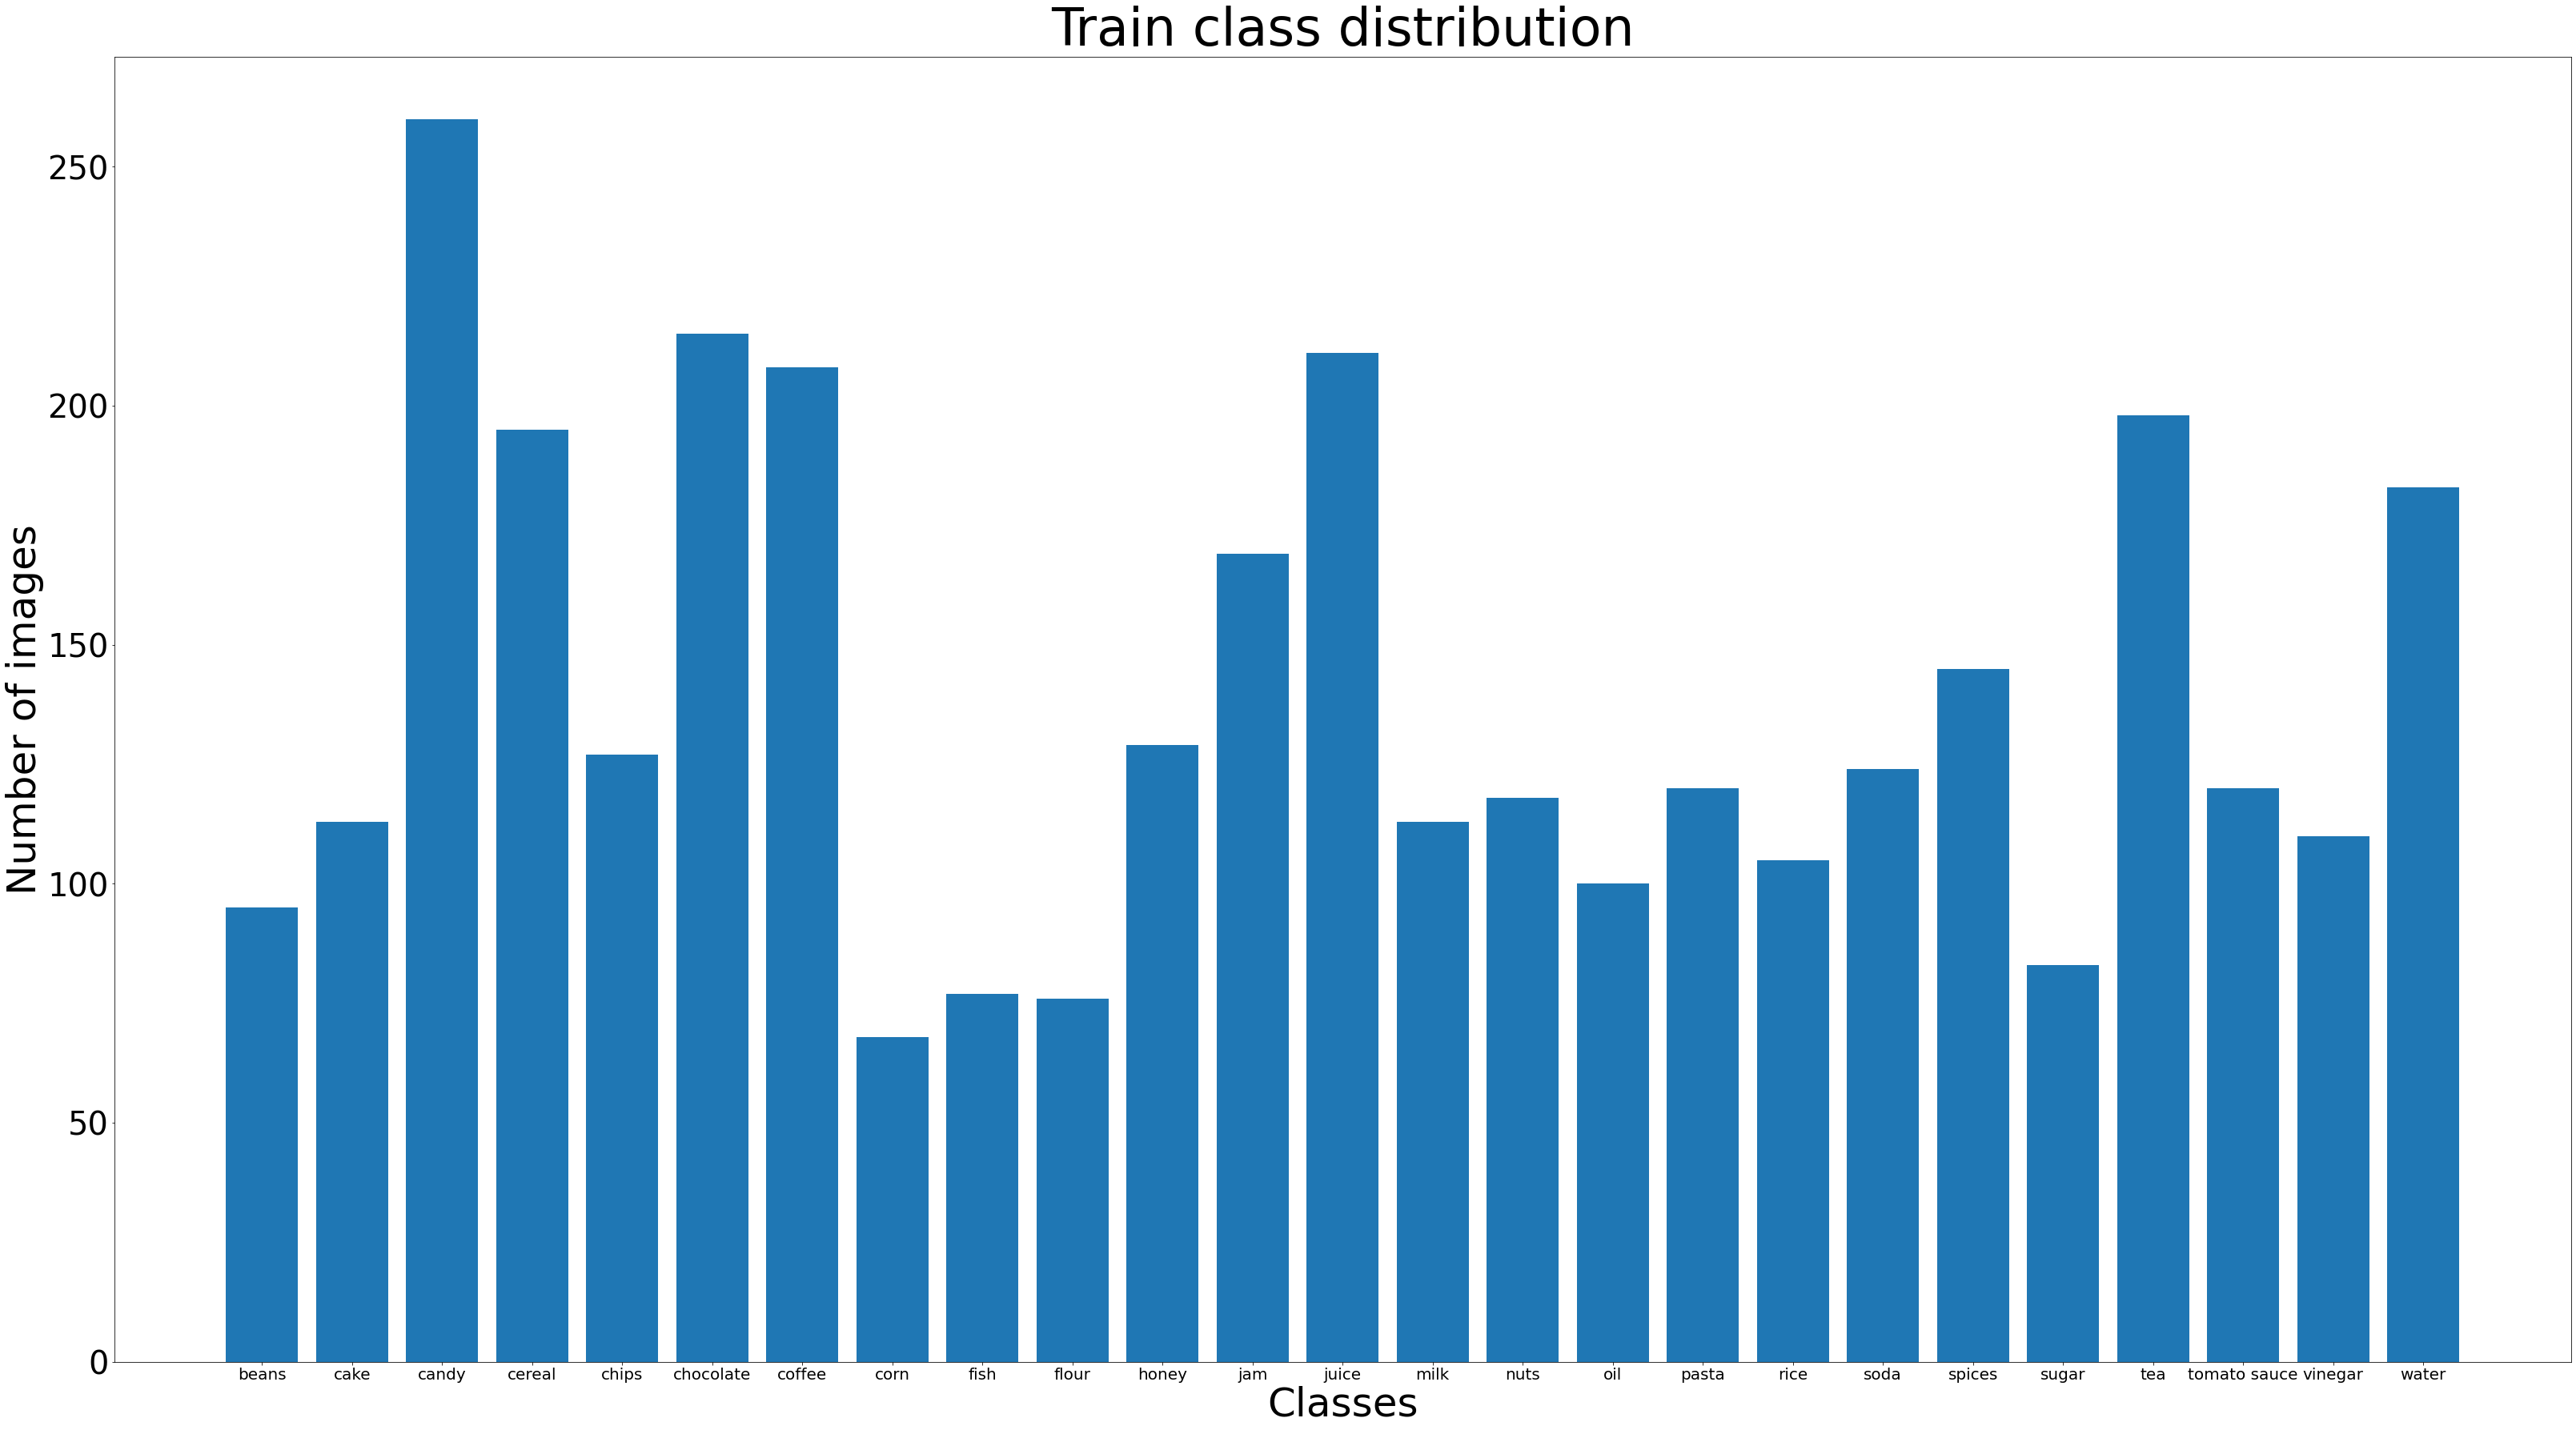

In [24]:
y_train_cls = np.argmax(y_train, axis = 1)
plt.figure(figsize=(55,30))
plt.title('Train class distribution', fontsize=65)
plt.xlabel('Classes', fontsize=50)
plt.ylabel('Number of images', fontsize=50)
plt.xticks(fontsize= 20)
plt.yticks(fontsize= 40)
plt.bar(classes_names,np.bincount(y_train_cls))
plt.show()

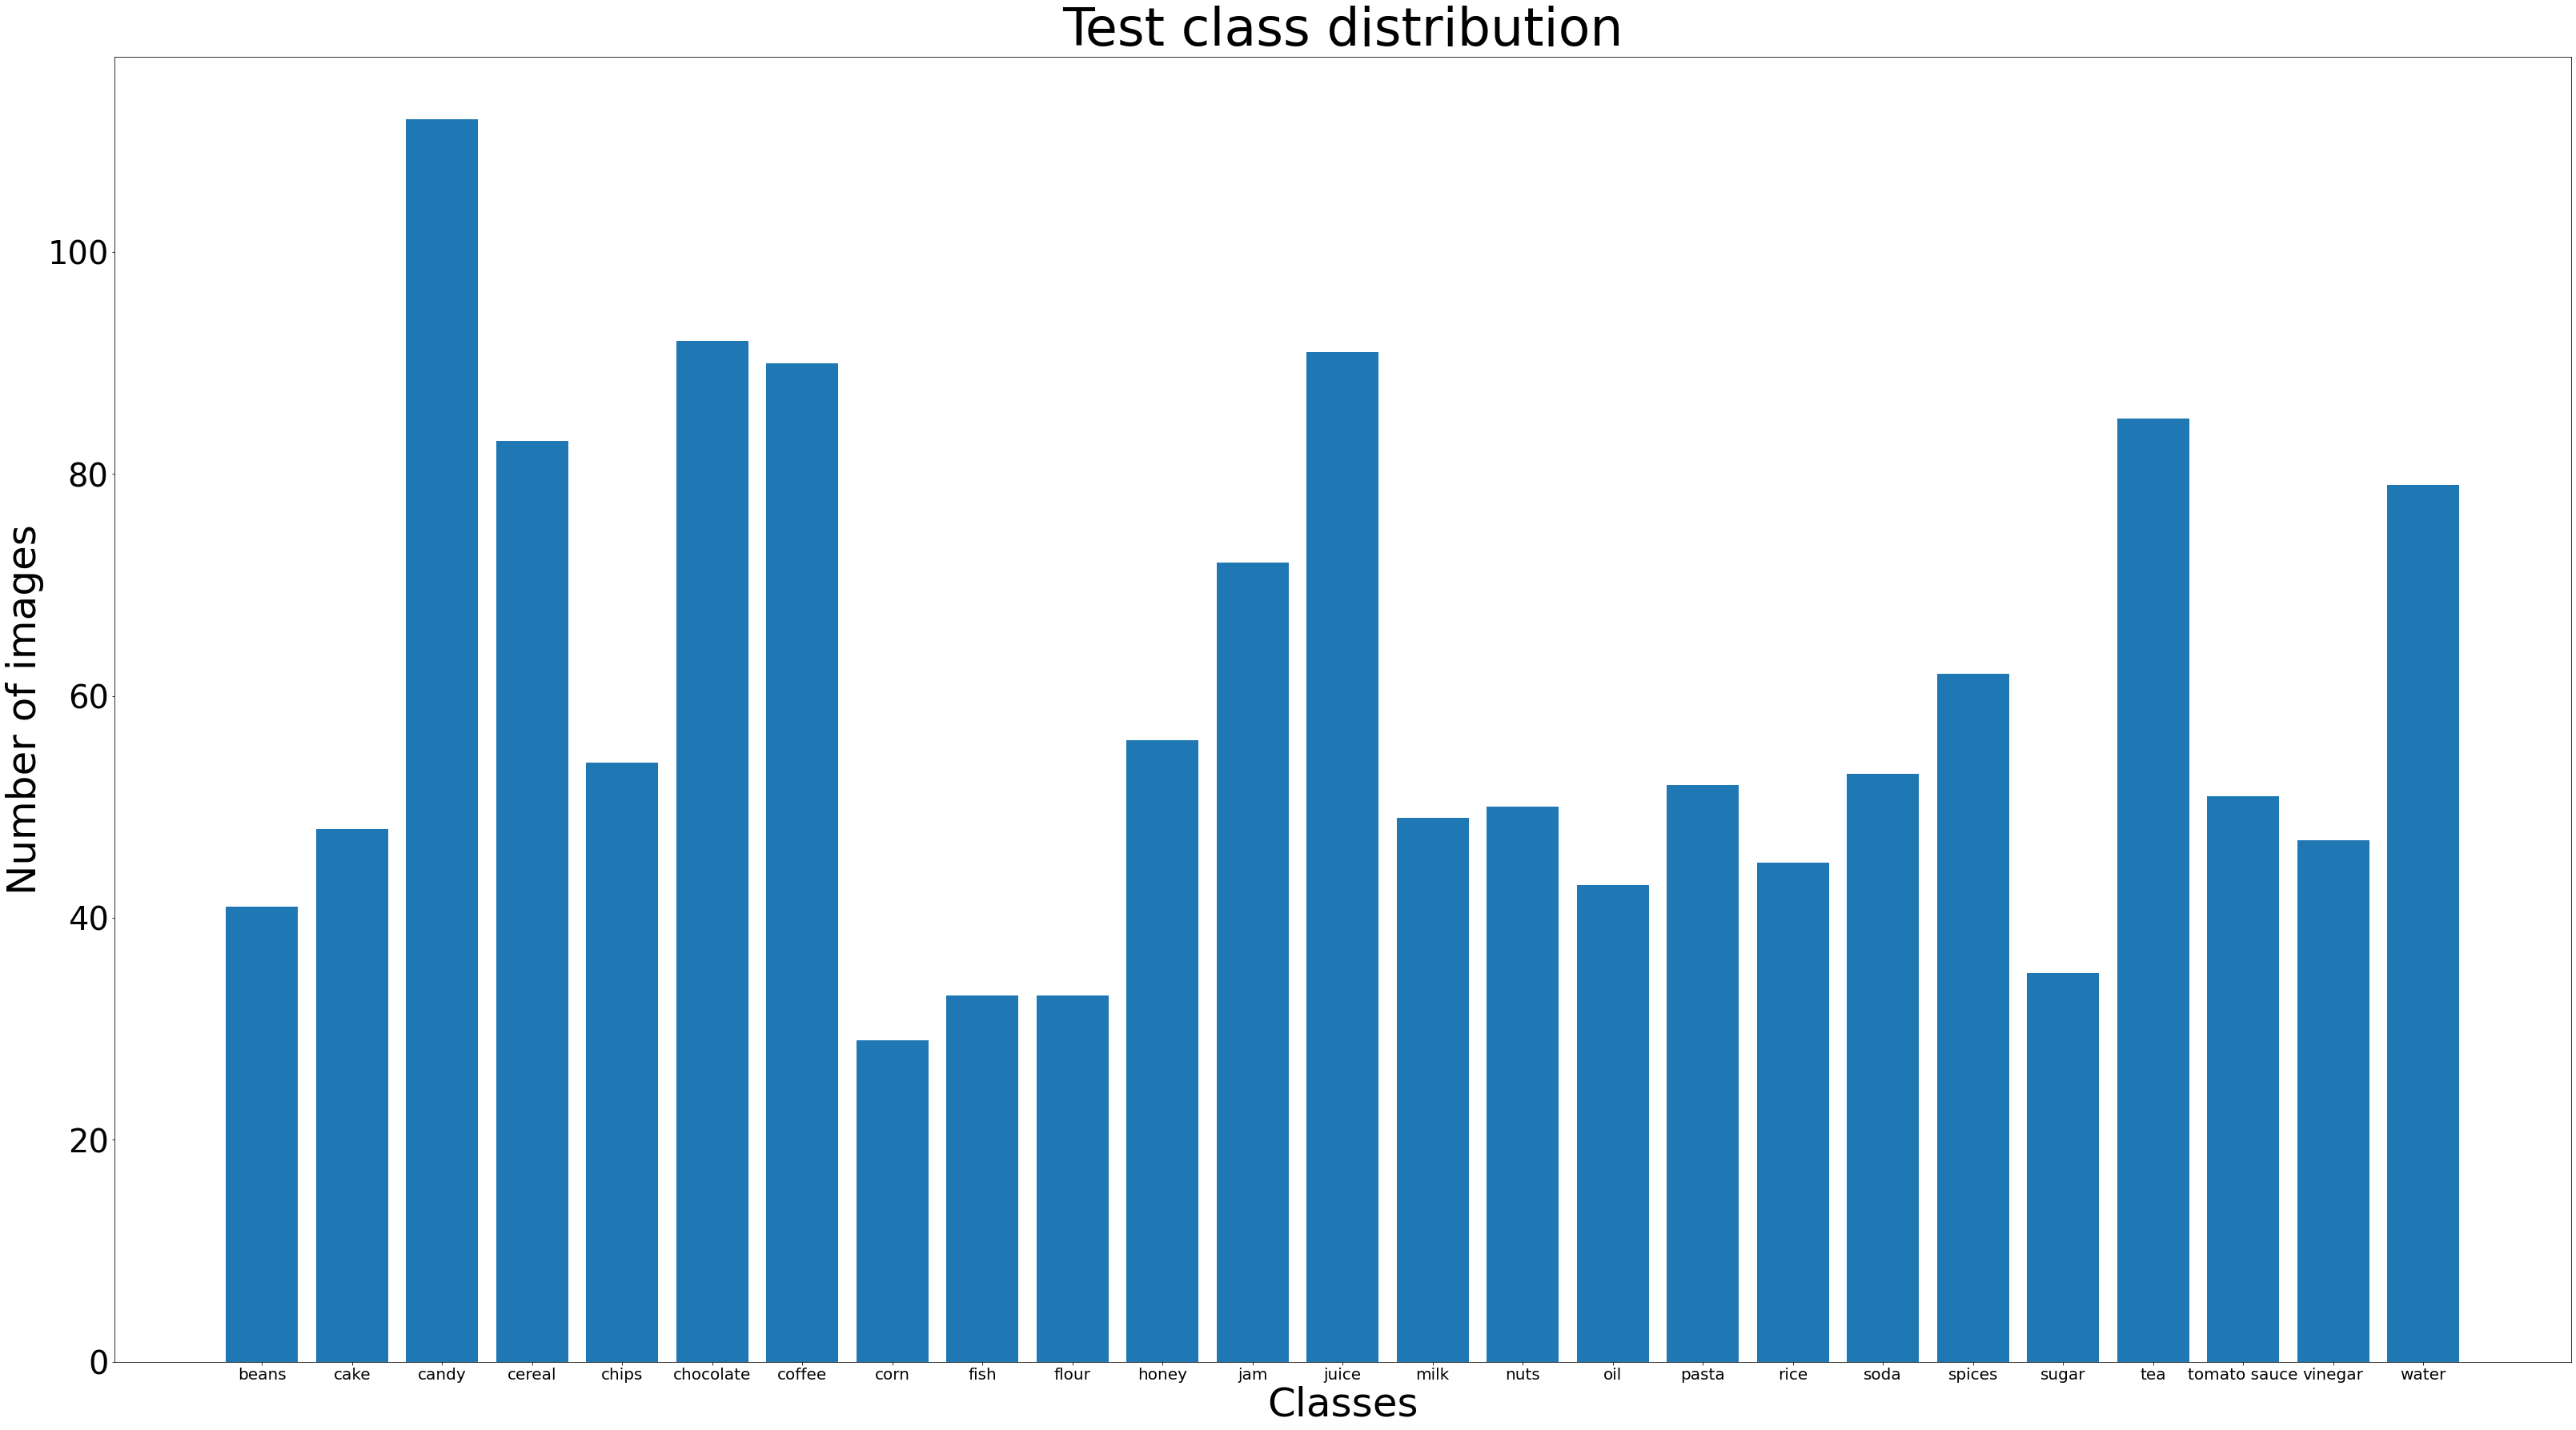

In [25]:
y_test_cls = np.argmax(y_test, axis = 1)
plt.figure(figsize=(55,30))
plt.title('Test class distribution', fontsize=65)
plt.xlabel('Classes', fontsize=50)
plt.ylabel('Number of images', fontsize=50)
plt.xticks(fontsize= 20)
plt.yticks(fontsize= 40)
plt.bar(classes_names,np.bincount(y_test_cls))
plt.show()

In [26]:
# image data generator
augs_gen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False, 
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10,  
        zoom_range = 0.1, 
        width_shift_range=0.2,  
        height_shift_range=0.2, 
        horizontal_flip=True,  
        vertical_flip=False,
        validation_split=0.3) 

augs_gen.fit(x_train)

In [27]:
img_rows = imgsize
img_cols = imgsize
img_rows, img_cols

(150, 150)

In [28]:
# channels_last img format
input_shape = (img_rows, img_cols, 3)
number_of_classes = 25

In [29]:
# model = test_model()
model = resNet_model(img_rows, img_cols)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x0000012C38E79BE0> False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x0000012C45C80820> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000012C45C80700> False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x0000012C46D02670> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x0000012C45C602B0> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x0000012C45C60B50> False
<tensorflow.python.keras.layers.core.Activation object at 0x0000012C47DEB1F0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000012C47DE6580> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x0000012C45C69FD0> False
<tensorflow.python.keras.layers.core.Activation object at 0x0000012C318900A0> False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x00

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Functional)     (None, 5, 5, 2048)        58331648  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 3072)              6294528   
_________________________________________________________________
dropout (Dropout)            (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)                76825     
Total params: 64,703,001
Trainable params: 6,371,353
Non-trainable params: 58,331,648
_________________________________________________________________


In [30]:
print_model(model, path_to_resNet_model_image)
# SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [31]:
checkpoint = ModelCheckpoint(
    filepath=path_to_resNet_model_weights,
    save_weights_only=True,
    monitor='accuracy',
    mode='max',
    save_best_only=True
)

csvlogger = CSVLogger(
    filename= path_to_resNet_csvlog,
    separator = ",",
    append = False
)


# Reduce learning rate when a metric has stopped improving
reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=7,
    verbose=1, 
    mode='auto'
)

callbacks = [checkpoint, csvlogger, reduce]

In [32]:
model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

history = model.fit(
                    augs_gen.flow(x_train, y_train, batch_size = 32,  subset='training'),
                    epochs = num_of_epochs,
                    verbose = 1,
                    validation_data  = augs_gen.flow(x_train, y_train, batch_size=16, subset='validation'),
                    callbacks=callbacks
                    )

Epoch 1/100
76/76 [==============================] - 285s 4s/step - loss: 2.8267 - accuracy: 0.3115 - val_loss: 2.0902 - val_accuracy: 0.4066
Epoch 2/100
76/76 [==============================] - 282s 4s/step - loss: 1.7191 - accuracy: 0.4884 - val_loss: 1.8718 - val_accuracy: 0.4682
Epoch 3/100
76/76 [==============================] - 284s 4s/step - loss: 1.4795 - accuracy: 0.5371 - val_loss: 1.8730 - val_accuracy: 0.4624
Epoch 4/100
76/76 [==============================] - 282s 4s/step - loss: 1.3313 - accuracy: 0.5903 - val_loss: 1.8856 - val_accuracy: 0.4509
Epoch 5/100
76/76 [==============================] - 283s 4s/step - loss: 1.2698 - accuracy: 0.6101 - val_loss: 1.7244 - val_accuracy: 0.5096
Epoch 6/100
76/76 [==============================] - 281s 4s/step - loss: 1.0825 - accuracy: 0.6679 - val_loss: 1.7080 - val_accuracy: 0.5231
Epoch 7/100
76/76 [==============================] - 279s 4s/step - loss: 1.0533 - accuracy: 0.6663 - val_loss: 1.7885 - val_accuracy: 0.5077
Epoch 

76/76 [==============================] - 278s 4s/step - loss: 0.1287 - accuracy: 0.9604 - val_loss: 1.6350 - val_accuracy: 0.6513
Epoch 53/100
76/76 [==============================] - 281s 4s/step - loss: 0.1346 - accuracy: 0.9641 - val_loss: 1.6239 - val_accuracy: 0.6262
Epoch 54/100
76/76 [==============================] - 280s 4s/step - loss: 0.1321 - accuracy: 0.9637 - val_loss: 1.5762 - val_accuracy: 0.6464
Epoch 55/100
76/76 [==============================] - 278s 4s/step - loss: 0.1248 - accuracy: 0.9616 - val_loss: 1.6154 - val_accuracy: 0.6291
Epoch 56/100
76/76 [==============================] - 279s 4s/step - loss: 0.1368 - accuracy: 0.9596 - val_loss: 1.6419 - val_accuracy: 0.6349
Epoch 57/100
76/76 [==============================] - 281s 4s/step - loss: 0.1271 - accuracy: 0.9691 - val_loss: 1.5691 - val_accuracy: 0.6320
Epoch 58/100
76/76 [==============================] - ETA: 0s - loss: 0.1295 - accuracy: 0.9641
Epoch 00058: ReduceLROnPlateau reducing learning rate to 1.

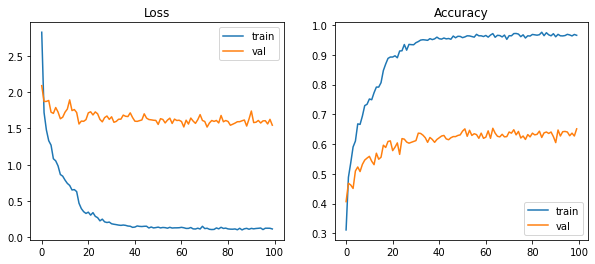

In [33]:
plot_acc_loss(history,num_of_epochs)

In [34]:
# MODEL EVALUATION

109/109 [==============================] - 269s 2s/step - loss: 0.4897 - accuracy: 0.8934
Test loss: 0.4897195100784302
Test accuracy: 0.8934141993522644
              precision    recall  f1-score   support

           0       0.91      0.88      0.90        95
           1       0.88      0.88      0.88       113
           2       0.92      0.94      0.93       260
           3       0.80      0.90      0.85       195
           4       0.82      0.88      0.85       127
           5       0.89      0.87      0.88       215
           6       0.86      0.89      0.87       208
           7       0.89      0.87      0.88        68
           8       0.97      0.92      0.95        77
           9       0.87      0.82      0.84        76
          10       0.95      0.92      0.94       129
          11       0.88      0.95      0.91       169
          12       0.88      0.91      0.90       211
          13       0.91      0.90      0.91       113
          14       0.86      0.81  

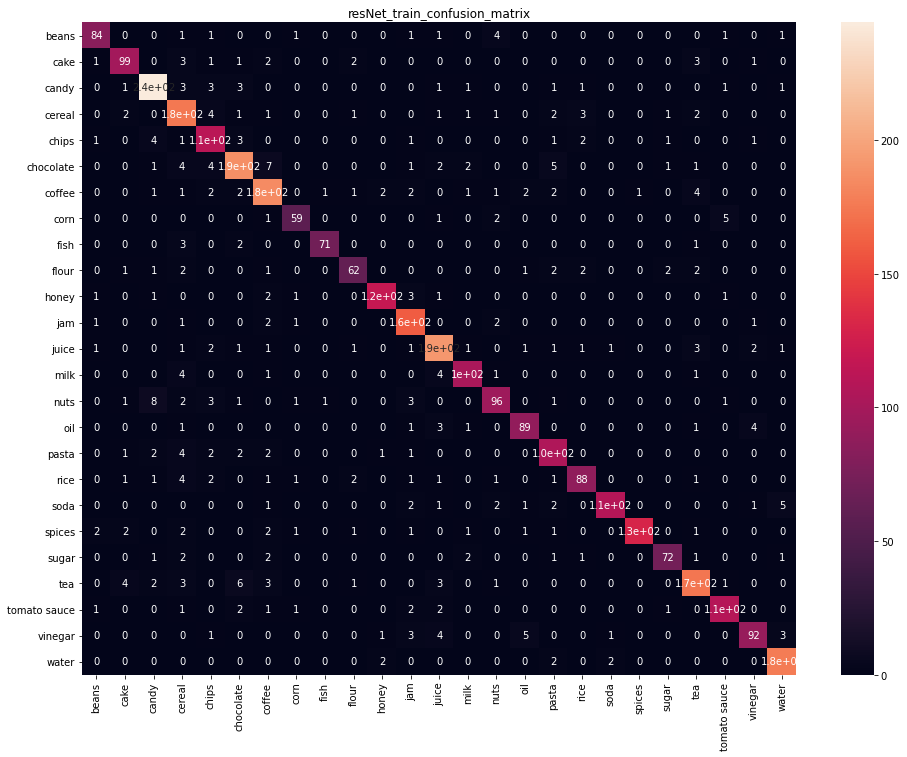

In [35]:
# TRAIN EVALUATION
evaluate_model(model,x_train,y_train,classes_names,"resNet_train_confusion_matrix")

47/47 [==============================] - 118s 3s/step - loss: 1.4530 - accuracy: 0.6801
Test loss: 1.453048825263977
Test accuracy: 0.680134654045105
              precision    recall  f1-score   support

           0       0.66      0.66      0.66        41
           1       0.74      0.67      0.70        48
           2       0.71      0.73      0.72       112
           3       0.59      0.77      0.67        83
           4       0.60      0.69      0.64        54
           5       0.59      0.58      0.58        92
           6       0.63      0.56      0.59        90
           7       0.68      0.66      0.67        29
           8       0.74      0.61      0.67        33
           9       0.71      0.45      0.56        33
          10       0.74      0.71      0.73        56
          11       0.71      0.85      0.77        72
          12       0.69      0.77      0.73        91
          13       0.69      0.69      0.69        49
          14       0.62      0.64      

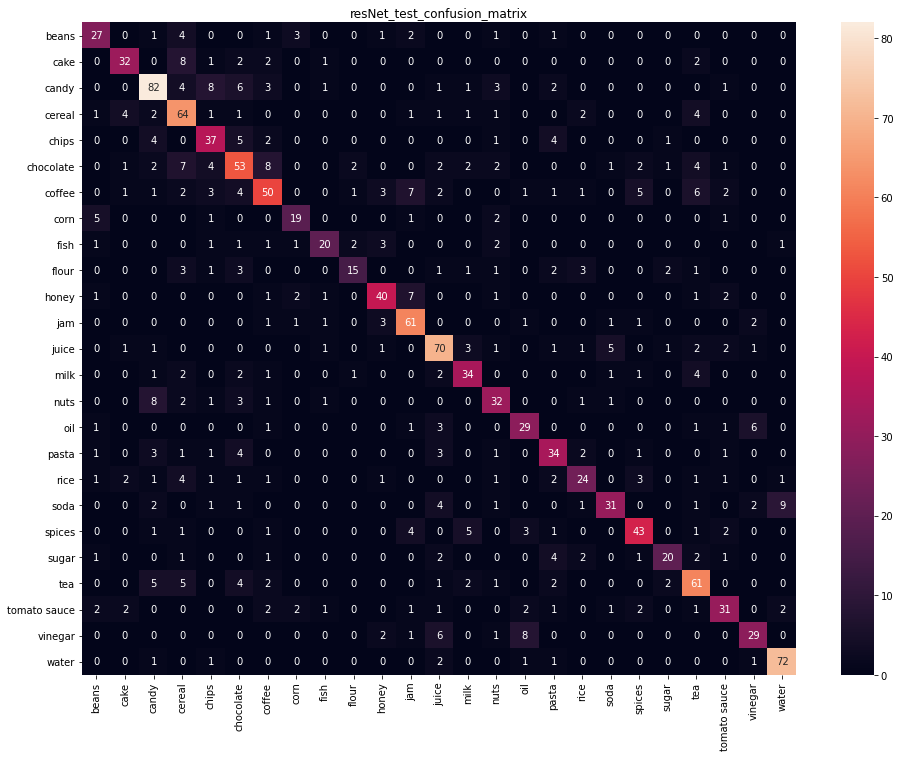

In [36]:
# TEST EVALUATION
evaluate_model(model,x_test,y_test,classes_names,"resNet_test_confusion_matrix")

In [37]:
# take weights with max acc
# ret = model.load_weights(path_to_resNet_model_weights)

In [38]:
# SAVING MODEL

In [39]:
write_model_as_json(model,resNet_model_json_path)

In [40]:
model.save(path_to_resNet_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./models/resNet\assets


In [41]:
# model1 = load_model(path_to_resNet_model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

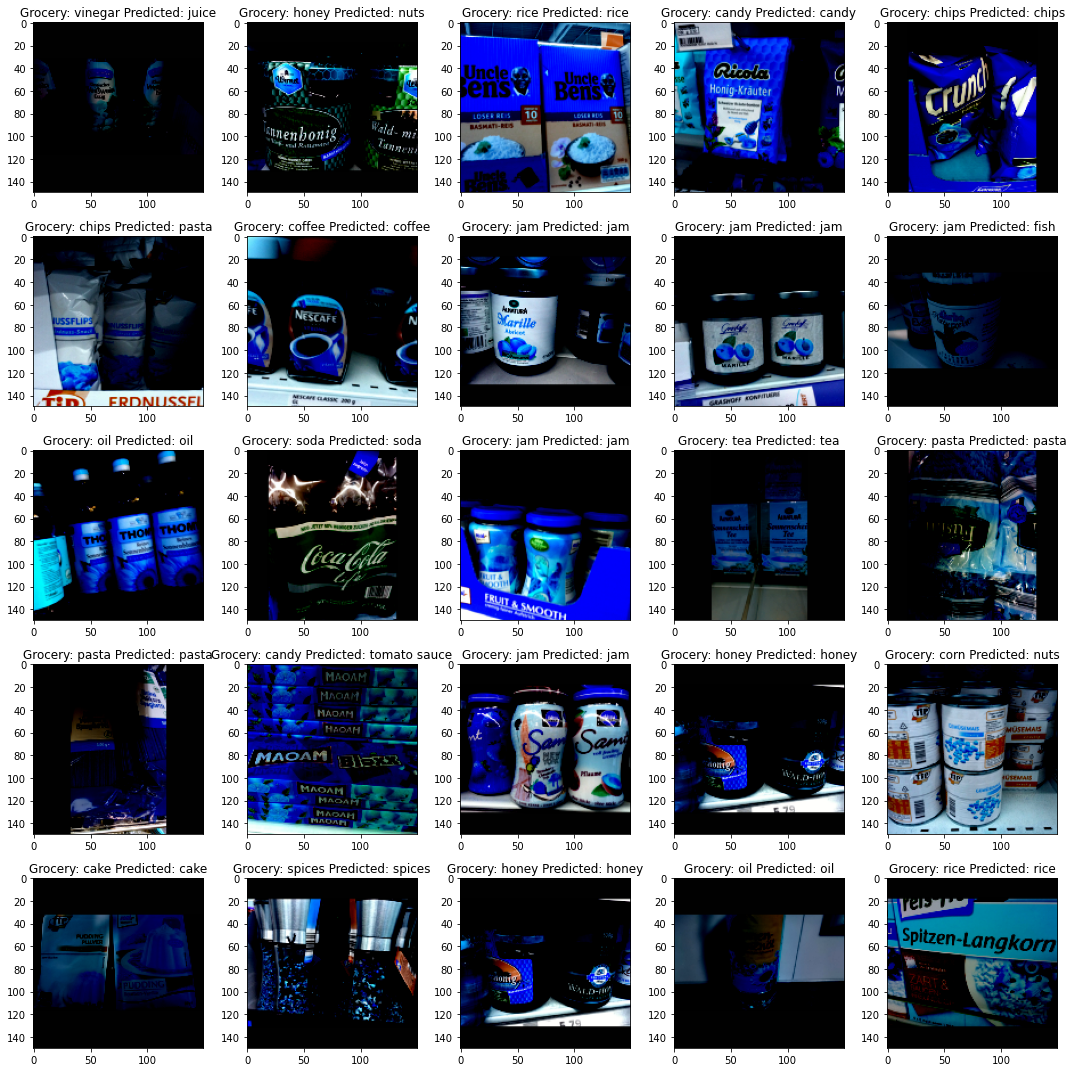

In [42]:
test_len = len(y_test)


fig,ax=plt.subplots(5,5)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range(5):
        k = rn.randint(0, test_len)
        ax[i,j].imshow(x_test[k])
        ax[i,j].set_title('Grocery: '+ classes_names[np.argmax(y_test[k])] + " Predicted: " + classes_names[np.argmax(model.predict(x_test[k:k+1]))])
plt.tight_layout()  